# Supplementary Information: Holmes *et al.* 2017

# 8. Unpooled treatment effects

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pickle
import pystan
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Supplementary_Info/SI_Holmes_etal_2016/venv-SI_Holmes_2016/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model

We extend our model to use groupwise (by *probe ID*) values for $\gamma_{j[i]}$ and $\delta{j[i]}$. We're now fitting a pooled model for the effect of going through the experiment (*control*) and individual models for each *probe ID* for the *treatment*

We therefore construct the following model of the experiment:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_i + \gamma_{j[i]} t_i + \delta_{j[i]} t_i x_i + \epsilon_i$$
$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta_{j[i]} \sim N(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\sigma_{\alpha} \sim U(0, 100)$$
$$\sigma_{\beta} \sim U(0, 100)$$

* $y_i$: measured intensity output on the array for probe $i$ (specific to each replicate)
* $x_i$: measured intensity input on the array for probe $i$ (specific to each replicate)
* $t_i$: 0/1 indicating whether the probe $i$ was measured in a control (0) or treatment (1) experiment
* $\alpha_{j[i]}$: the linear intercept, this is a constant 'offset' for all *output* measurements relative to *input* measurements, but it differs for each *probe ID*; this is drawn from a Normal distribution $\sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$
* $\mu_{\alpha}$: the mean offset for all *probe ID*s
* $\sigma_{\alpha}$: the standard deviation of the offset for all *probe ID*s - sampled from a Uniform distribution $U(0, 100)$
* $\beta_{j[i]}$: the linear slope, this is the relative change in measured intensity between *input* and *output* intensities *at the probe ID level* - it differs for each *probe ID*; this is drawn from a Normal distribution $\sim N(\mu_{\beta}, \sigma_{\beta}^2)$
* $\mu_{\beta}$: the mean slope for all *probe ID*s
* $\sigma_{\beta}$: the standard deviation of the slope for all *probe ID*s - sampled from a Uniform distribution $U(0, 100)$
* $\gamma_{j[i]}$: a groupwise estimate of the influence on *output* measured intensity of introducing passage (*treatment*) into the experiment (i.e. an intercept correction)
* $\delta_{j[i]}$: a groupwise estimate of the influence on *output* measured intensity of introducing passage (*treatment*) into the experiment, as a function of the *input* measured intensity (i.e. a slope correction)
* $\epsilon_i$: error in the model prediction for probe $i$

### Stan model construction and fit

We need to define `data`, `parameters` and our `model` for `Stan`.

In the `data` block, we have:

* `N`: `int`, the number of data points)
* `J`: `int`, the number of unique probe IDs (`J` < `N`)
* `probe`: `int[N]`, an index list of probe identities - one index representing six probe measurements (i.e. three control, three treatment) - there are `J` probes
* `t`: `vector[N]`, 0/1 control/treatment values for each probe
* `x`: `vector[N]`, the input log(intensity) values
* `y`: `vector[N]`, the output log(intensity) values

In the `parameter` block, we have:

* `a`: `real vector[J]`, representative input log(intensity)
* `mu_a`: `real`, an unconstrained value to be fit that represents the mean offset for each probe ID
* `b`: `real vector[J]`, effect on log(intensity) of passing through the experiment, specific to a probe ID
* `mu_b`: `real`, an unconstrained value to be fit that represents the mean slope for each probe ID
* `g`: `real vector[J]`, estimate of the influence of treatment on the output measured intensity (offset)
* `d`: `real vector[J]`, estimate of the influence of treatment on the output measured intensity (slope)
* `sigma`: `real<lower=0>`, the error in the prediction
* `sigma_a`: `real<lower=0,upper=100>`, standard deviation of the offset per probe ID
* `sigma_b`: `real<lower=0,upper=100>`, standard deviation of the slope per probe ID

We also define a `transformed parameter`:

* `y_hat[i] <- b[probe[i]] * x[i] + a[probe[i]] + g[probe[i]] * t[i] + d[probe[i]] * t[i] * x[i]`: the linear relationship describing $\hat{y}$, our estimate of experimental output intensity, which is subject to variance `sigma`.

We define the model as:

$$\sigma_{\alpha} \sim U(0, 100)$$
$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\sigma_{\beta} \sim U(0, 100)$$
$$\beta_{j[i]} \sim N(\mu_{\beta}, \sigma_{\beta}^2)$$
$$y \sim N(\hat{y}, \sigma^2)$$


In [2]:
# load clean, normalised, indexed data
# data = pd.read_csv("output/normalised_array_data.tab", sep="\t")  # full dataset
data = pd.read_csv("output/reduced_normalised_probe_indexed_array_data.tab", sep="\t")  # reduced dataset for test

# useful values
probe_ids = data['probe'].unique()
nprobes = len(probe_ids)

In [ ]:
# define unpooled stan model
treatment_model = """
data {
  int<lower=0> N;
  int<lower=0> J;
  int<lower=1, upper=J> probe[N];
  vector[N] t;
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[J] a;
  vector[J] b;
  vector[J] g;
  vector[J] d;
  real mu_a;
  real mu_b;
  real<lower=0> sigma;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_b;
}
transformed parameters{
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] = a[probe[i]] + b[probe[i]] * x[i] + g[probe[i]] * t[i] + d[probe[i]] * t[i] * x[i];
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal(mu_a, sigma_a);

  sigma_b ~ uniform(0, 100);
  b ~ normal(mu_b, sigma_b);

y ~ normal(y_hat, sigma);
}
"""

In [ ]:
# relate python variables to stan variables
treatment_data_dict = {'N': len(data),
                       'J': nprobes,
                       'probe': data['probe_index'] + 1,
                       't': data['treatment'],
                       'x': data['log_input'],
                       'y': data['log_output']}

In [ ]:
# run stan fit
treatment_fit = pystan.stan(model_code=treatment_model,
                            data=treatment_data_dict,
                            iter=1000, chains=2,
                            seed=tools.SEED)

In [ ]:
# Save model to file, for reuse# Save fit to file, for reuse
unpermutedChains = treatment_fit.extract()

unpermutedChains_df = pd.DataFrame([dict(unpermutedChains)])
pickle.dump(unpermutedChains_df, open('output/2016-12-05_notebook08.pkl', 'wb'))

In [3]:
treatment_fit = pickle.load(open('output/2016-12-05_notebook08.pkl', 'rb'))

## Inspecting the fit

Our primary interest now returns to groupwise values, but this time of the effect due to the *treatment* in the experiment.

In [4]:
# Get fits to alpha, beta, gamma by probe ID
alpha_estimates = pd.Series(treatment_fit['a'].mean(0), index=probe_ids)
alpha_se = pd.Series(treatment_fit['a'].std(0), index=probe_ids)
beta_estimates = pd.Series(treatment_fit['b'].mean(0), index=probe_ids)
beta_se = pd.Series(treatment_fit['b'].std(0), index=probe_ids)
gamma_estimates = pd.Series(treatment_fit['g'].mean(0), index=probe_ids)
gamma_se = pd.Series(treatment_fit['g'].std(0), index=probe_ids)
delta_estimates = pd.Series(treatment_fit['d'].mean(0), index=probe_ids)
delta_se = pd.Series(treatment_fit['d'].std(0), index=probe_ids)

Exception: Data must be 1-dimensional

In [14]:
# Get fits to alpha, beta, gamma by probe ID IF LOADED FROM PICKLE!
alpha_estimates = pd.Series(treatment_fit['a'][0].mean(0), index=probe_ids)
alpha_se = pd.Series(treatment_fit['a'][0].std(0), index=probe_ids)
beta_estimates = pd.Series(treatment_fit['b'][0].mean(0), index=probe_ids)
beta_se = pd.Series(treatment_fit['b'][0].std(0), index=probe_ids)
gamma_estimates = pd.Series(treatment_fit['g'][0].mean(0), index=probe_ids)
gamma_se = pd.Series(treatment_fit['g'][0].std(0), index=probe_ids)
delta_estimates = pd.Series(treatment_fit['d'][0].mean(0), index=probe_ids)
delta_se = pd.Series(treatment_fit['d'][0].std(0), index=probe_ids)

In [15]:
# Inspect the estimates
alpha_estimates.head()

A_07_P052986   -0.704691
A_07_P045401   -0.615652
A_07_P052976   -0.595220
A_07_P045384   -0.820404
A_07_P045369    0.242992
dtype: float64

In [16]:
# Inspect the estimates
beta_estimates.head()

A_07_P052986    1.008496
A_07_P045401    1.007126
A_07_P052976    1.007623
A_07_P045384    1.006511
A_07_P045369    1.008565
dtype: float64

In [17]:
# Inspect the estimates
gamma_estimates.head()

A_07_P052986    1.971032
A_07_P045401    1.405168
A_07_P052976    1.228307
A_07_P045384    1.421544
A_07_P045369   -1.977641
dtype: float64

In [18]:
# Inspect the estimates
delta_estimates.head()

A_07_P052986    -1.240449
A_07_P045401    -0.721636
A_07_P052976    -0.969448
A_07_P045384    -0.960945
A_07_P045369    11.438618
dtype: float64

### Intercepts $\alpha_{j[i]}$

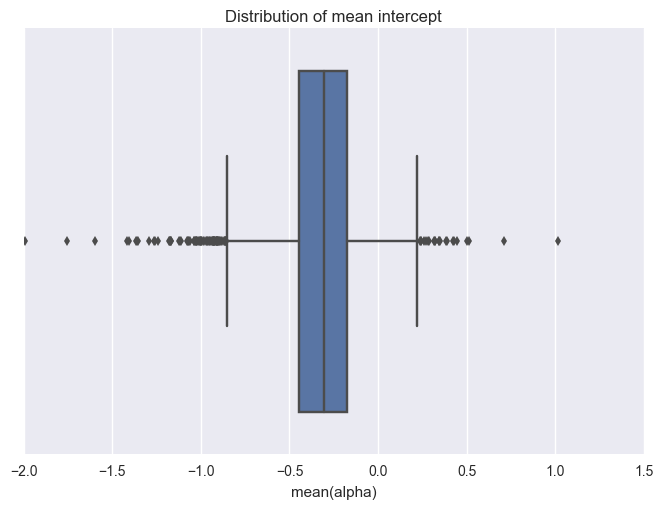

In [19]:
# Plot means distribution
g = sns.boxplot(alpha_estimates)
g.set_title("Distribution of mean intercept")
g.set_xlabel("mean(alpha)");

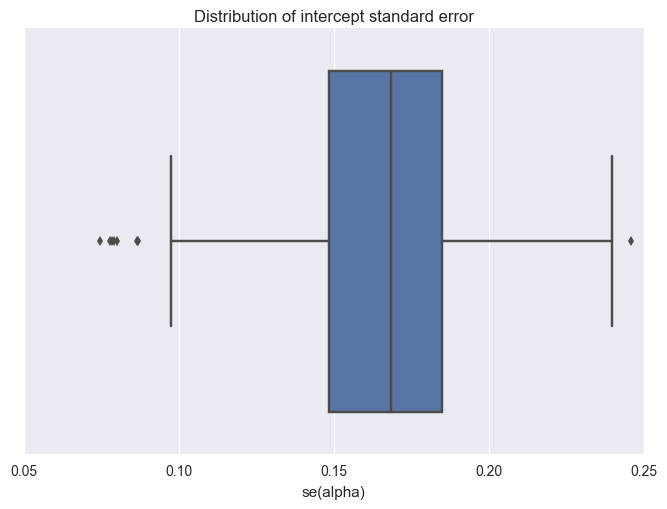

In [20]:
# Plot means distribution
g = sns.boxplot(alpha_se)
g.set_title("Distribution of intercept standard error")
g.set_xlabel("se(alpha)");

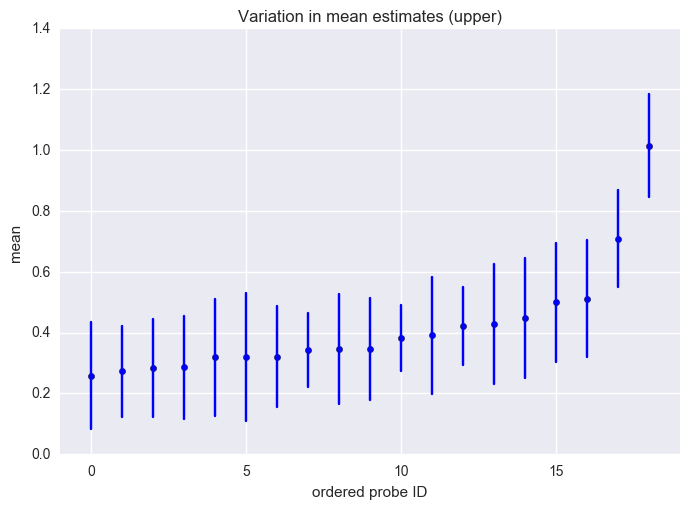

In [21]:
# errors for intercept outliers
tools.plot_threshold_errors(alpha_estimates, alpha_se, 0.25)

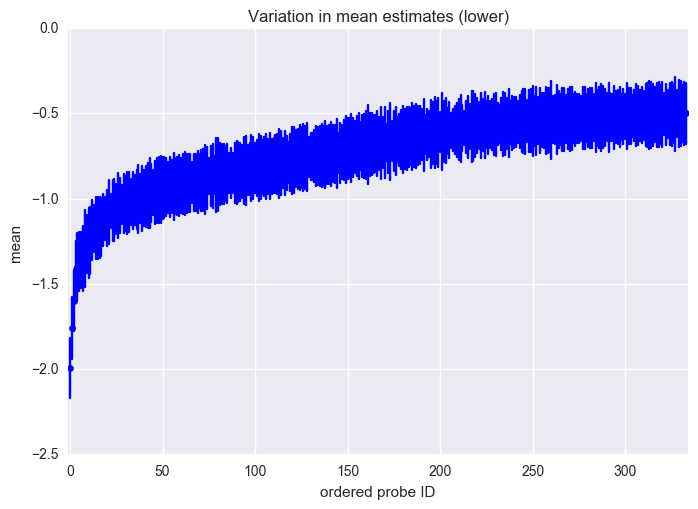

In [22]:
# errors for intercept outliers
tools.plot_threshold_errors(alpha_estimates, alpha_se, -0.5, upper=False)

### Slopes $\beta_{j[i]}$

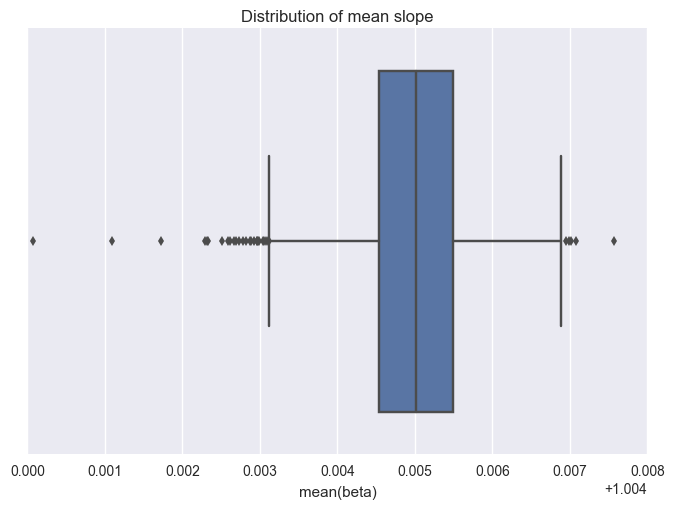

In [23]:
# Plot means distribution
g = sns.boxplot(beta_estimates)
g.set_title("Distribution of mean slope")
g.set_xlabel("mean(beta)");

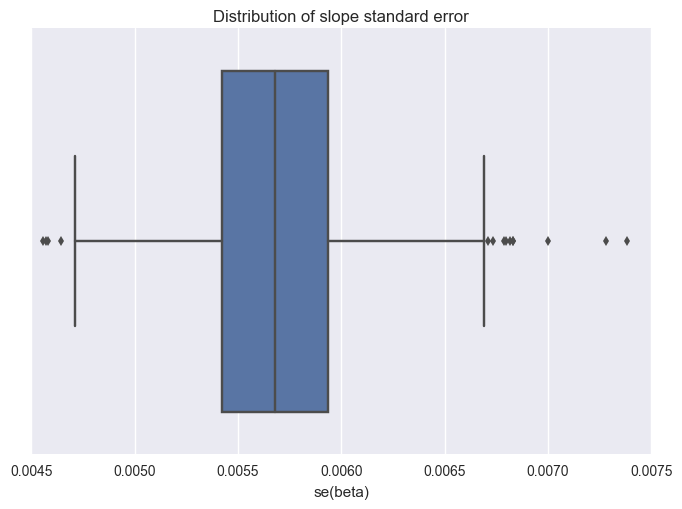

In [24]:
# Plot means distribution
g = sns.boxplot(beta_se)
g.set_title("Distribution of slope standard error")
g.set_xlabel("se(beta)");

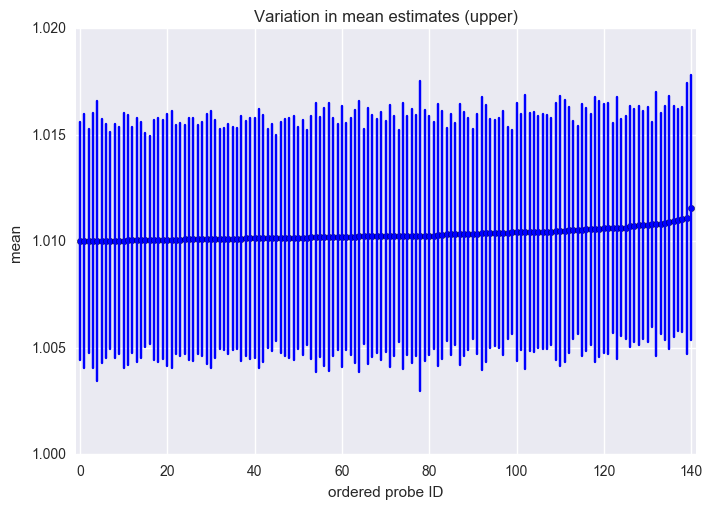

In [41]:
# errors for intercept outliers
tools.plot_threshold_errors(beta_estimates, beta_se, 1.01)

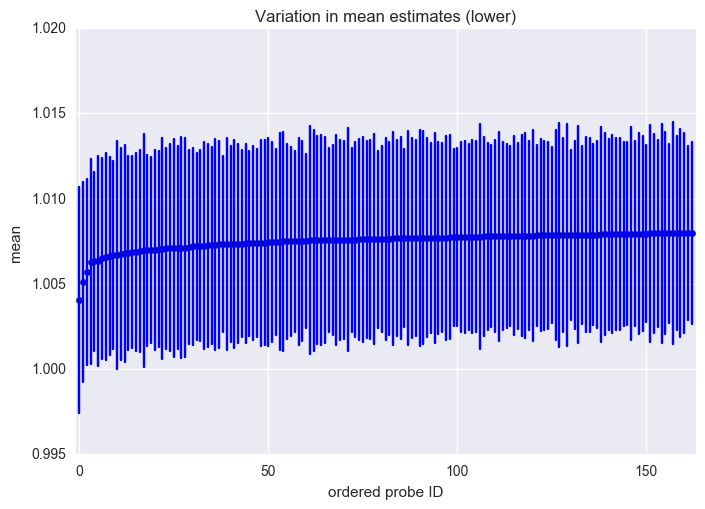

In [39]:
# errors for intercept outliers
tools.plot_threshold_errors(beta_estimates, beta_se, 1.008, upper=False)

### Intercepts $\gamma_{j[i]}$

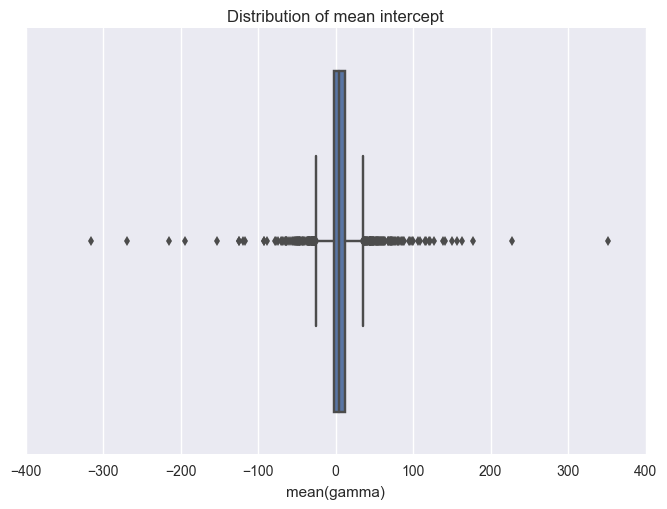

In [28]:
# Plot means distribution
g = sns.boxplot(gamma_estimates)
g.set_title("Distribution of mean intercept")
g.set_xlabel("mean(gamma)");

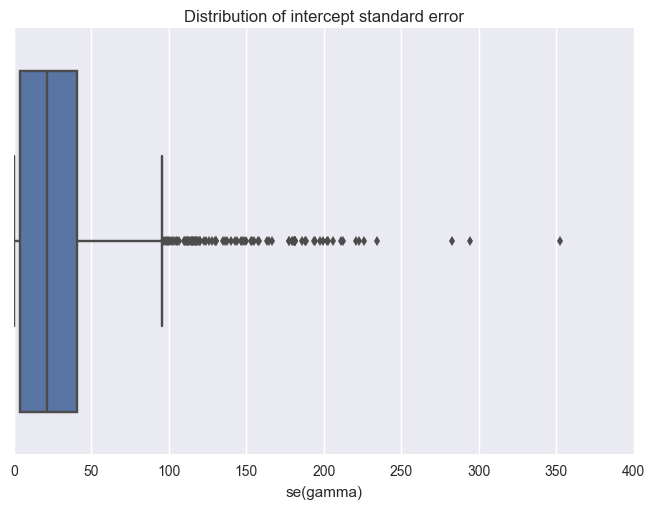

In [29]:
# Plot means distribution
g = sns.boxplot(gamma_se)
g.set_title("Distribution of intercept standard error")
g.set_xlabel("se(gamma)");

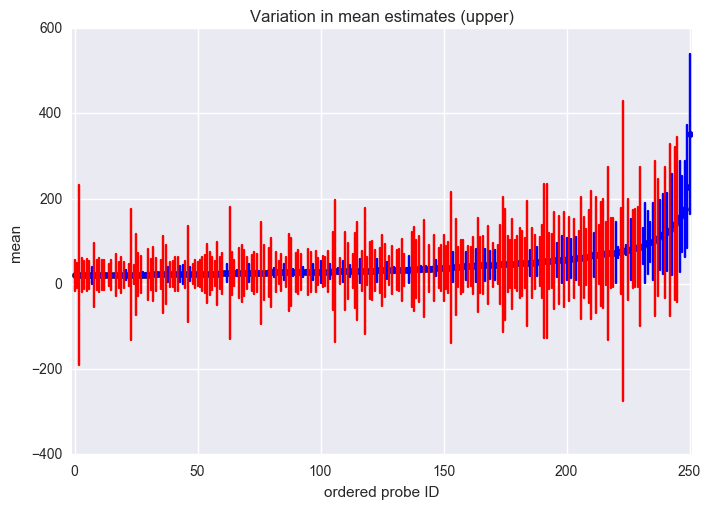

In [30]:
# errors for intercept outliers
tools.plot_threshold_errors(gamma_estimates, gamma_se, 20)

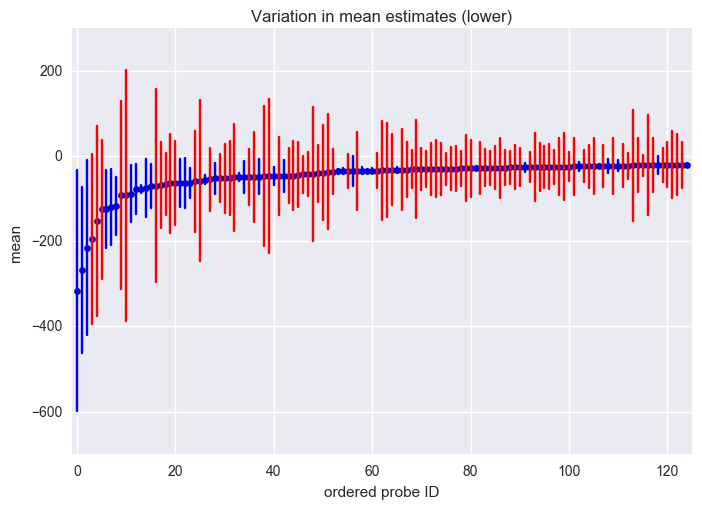

In [31]:
# errors for intercept outliers
tools.plot_threshold_errors(gamma_estimates, gamma_se, -20, upper=False)

### Slopes $\delta_{j[i]}$

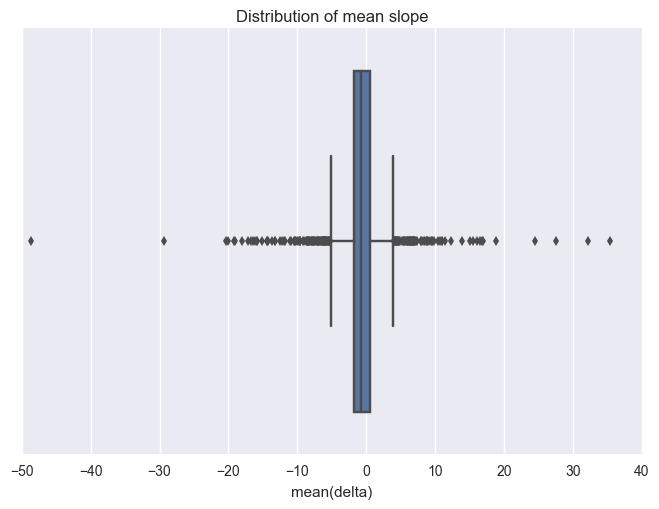

In [32]:
# Plot means distribution
g = sns.boxplot(delta_estimates)
g.set_title("Distribution of mean slope")
g.set_xlabel("mean(delta)");

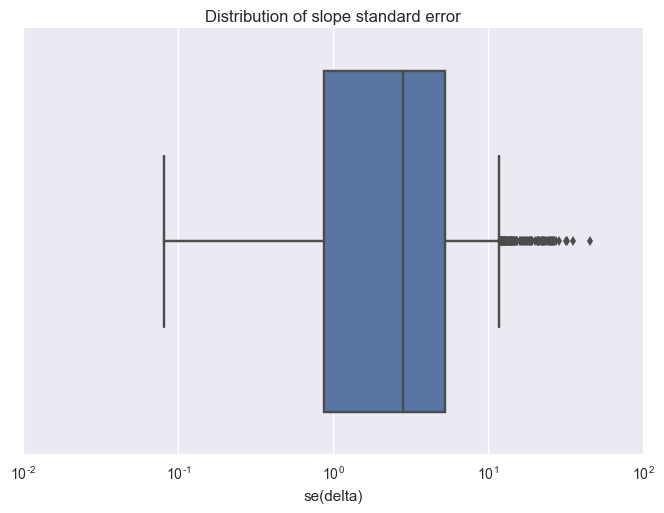

In [33]:
# Plot means distribution
g = sns.boxplot(delta_se)
g.set_title("Distribution of slope standard error")
g.set_xscale("log")
g.set_xlabel("se(delta)");

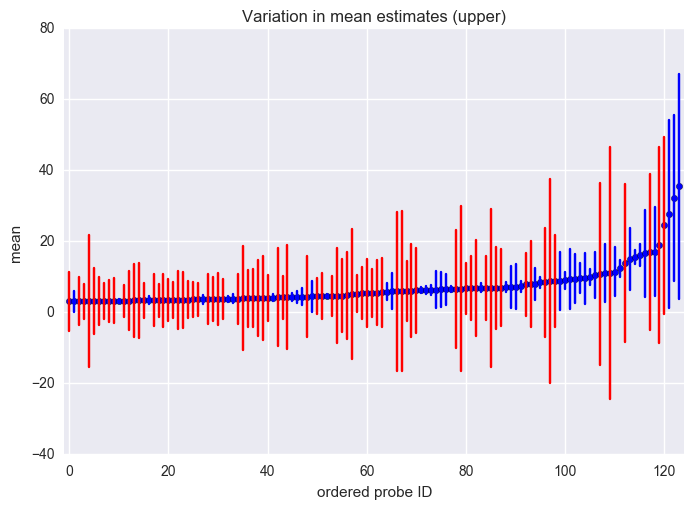

In [34]:
# errors for intercept outliers
tools.plot_threshold_errors(delta_estimates, delta_se, 3)

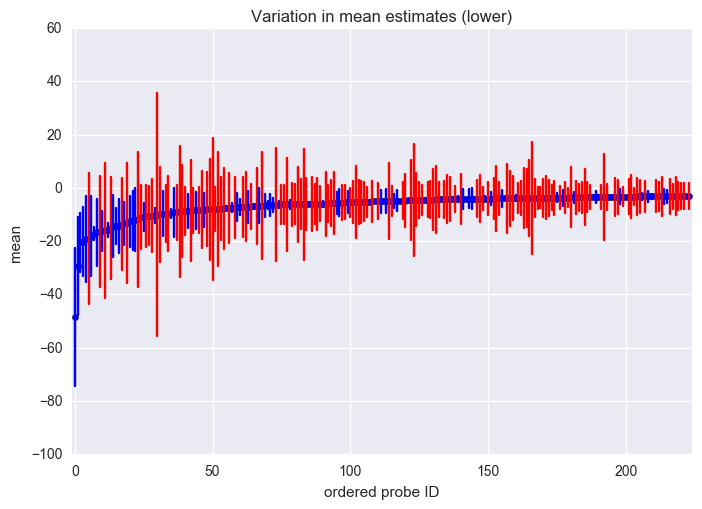

In [35]:
# errors for intercept outliers
tools.plot_threshold_errors(delta_estimates, delta_se, -3, upper=False)

In [36]:
# Add delta estimates to dataframe
df_delta = tools.df_add_coefficient(data, 'd', delta_estimates, delta_se, 'probe')